In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import yaml
import os
from sklearn.cluster import KMeans
from skimage.morphology import skeletonize


In [2]:
def load_and_parse_config(config_path):
    """
    从指定路径加载YAML配置文件，并解析出特定配置项。

    参数:
        config_path (str): YAML配置文件的路径。

    返回:
        tuple: 包含如下元素的元组：
            - 模板图像路径
            - 精度
            - 单位
            - 标注点坐标列表
            - 标注点对应的值列表
            - 扫描区域中心点坐标
            - 扫描区域半径
            - 模板指针宽度（像素）
    """
    with open(config_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)

    # 解析并获取配置项
    template_image_path = config.get('template_path')
    PRECISION = config.get('precision')
    UNIT = config.get('unit')
    candidate_pointss = config.get('candidate_points', [])
    candidate_pointss_value = config.get('candidate_points_value', [])
    scan_zone = config.get('scan_zone', {})
    zone_point = scan_zone.get('center_point', [0, 0])
    zone_radius = scan_zone.get('radius', 0.0)
    pointer_width = scan_zone.get('width', 0.0)
    pointer_num = scan_zone.get('pointer_num', 0)

    assert len(candidate_pointss) == len(candidate_pointss_value)
    return (
        template_image_path, PRECISION, UNIT,
        candidate_pointss, candidate_pointss_value,
        zone_point, zone_radius, pointer_width, pointer_num
    )

In [3]:
# 展示图片
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

# 绘制点集在图片上 （reversed控制图片坐标系或真实坐标系）
def show_point(image, x_point, y_point, color=(0, 255, 255)):
    # 复制图像以避免修改原始图像
    image_temp = image.copy()

    # 检查是否是灰度图像并转换为BGR颜色空间
    if len(image_temp.shape) == 2:  # 如果图像只有高度和宽度，则为灰度图像
        image_temp = cv2.cvtColor(image_temp, cv2.COLOR_GRAY2BGR)
    # 计算较短的一边
    shortest_side = min(image.shape[0], image.shape[1])

    # 定义点占图像最短边的比例
    point_radius_percentage = 0.008
    # 计算半径
    radius = int(shortest_side * point_radius_percentage)

    # 确保半径至少为1像素，以便绘制的点可见
    radius = max(1, radius)

    # 绘制点
    for (x, y) in zip(x_point, y_point):
        cv2.circle(image_temp, (int(x), int(y)), radius, color, -1)
    show_img(image_temp)

In [4]:
def my_fun_circle(parameters, x_samples, y_samples):
    x_c, y_c, r = parameters
    distance_to_center = np.sqrt((x_samples - x_c) ** 2 + (y_samples - y_c) ** 2)
    return distance_to_center - r

def fit_circle(x_samples, y_samples):
    initial_guess = [np.mean(x_samples), np.mean(y_samples), np.sqrt((x_samples[0] - np.mean(x_samples))**2 + (y_samples[0] - np.mean(y_samples))**2)]
    result = least_squares(my_fun_circle, initial_guess, args=(x_samples, y_samples))
    x_c, y_c, r = result.x
    return x_c, y_c, r

def Point_in_circle(x, y, r, theta):
    x_point = x + r * np.cos(theta)
    y_point = y + r * np.sin(theta)
    return x_point, y_point

In [5]:
def SIFT4H(img1, img2, debug):

    # 初始化SIFT检测器
    sift = cv2.SIFT_create()
    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 参数设计
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # 或传递一个空字典

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 准备计算单应性矩阵的数据
    good_matches = []
    pts1 = []
    pts2 = []

    # 应用比例测试
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 2)
    pts2 = np.float32(pts2).reshape(-1, 2)

    # 获取单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),  # 只绘制内部点
                       flags=2)


    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    if not debug: return H
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.show()

    return H

In [6]:
def save_cv_image_with_plt(cv_image, output_path):
    # 如果图像是彩色的，则将其从BGR转换为RGB
    if len(cv_image.shape) == 3:
        rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = cv_image  # 灰度图像不需要转换

    # 创建一个新的图形，并关闭坐标轴
    plt.figure()
    plt.axis('off')  # 关闭坐标轴
    plt.gca().set_axis_off()  # 隐藏边框

    # 显示图像
    plt.imshow(rgb_image, cmap='gray' if len(cv_image.shape) == 2 else None)

    # 保存图像到文件，bbox_inches='tight' 和 pad_inches=0 用来去掉边缘空白
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()  # 关闭当前图形以释放内存

In [7]:
# 使用单应矩阵 对点进行转换
# 图像坐标系
def transform_point_with_H(x_point, y_point, H):
    point = np.array([x_point, y_point], dtype=np.float32).T
    projected_points = (cv2.perspectiveTransform(point.reshape(-1,1,2), H).reshape(-1,2).T)
    return projected_points[0], projected_points[1]


def warp_image_and_points_with_H(H, img2, x_point, y_point):
    # 获取img2的尺寸
    height, width = img2.shape[:2]

    # 定义img2四个角点的位置
    corners = np.float32([[0, 0], [0, height], [width, height], [width, 0]]).reshape(-1, 1, 2)

    # 使用perspectiveTransform来找到四个角点变换后的位置
    transformed_corners = cv2.perspectiveTransform(corners, H)

    # 找到变换后的最小外接矩形
    x_min = min(transformed_corners[:, 0, 0])
    y_min = min(transformed_corners[:, 0, 1])
    x_max = max(transformed_corners[:, 0, 0])
    y_max = max(transformed_corners[:, 0, 1])

    # 计算新图像的宽度和高度
    new_width = int(np.round(x_max - x_min))
    new_height = int(np.round(y_max - y_min))

    # 调整H矩阵，使得变换后的图像不被裁剪
    translation_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
    adjusted_H = np.dot(translation_matrix, H)

    # 应用透视变换到图像
    warped_img2 = cv2.warpPerspective(img2, adjusted_H, (new_width, new_height))

    # 将输入的点转换为正确的格式，并应用相同的变换矩阵
    points = np.array([x_point, y_point], dtype=np.float32).T.reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(points, translation_matrix).reshape(-1, 2).T
    # 返回变换后的图像和点集
    return warped_img2, transformed_points[0], transformed_points[1]


In [8]:
def cross(x1, y1, x2, y2):
    return x1 * y2 - x2 * y1

def dot(x1, y1, x2, y2):
    return x1 * x2 + y1 * y2

def mask_in_circle(img, x, y, r):
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    dist_from_center = np.sqrt((X - x) ** 2 + (Y - y) ** 2)
    circle_mask = dist_from_center <= r
    return circle_mask

def crop_with_mask(img, mask, x0, y0, crop=True):
    # Apply the mask to the image
    img_masked = img.copy()

    if img.ndim == 3:
        img_masked[~mask] = [0, 0, 0]
    else :
        img_masked[~mask] = 0

    if not crop: return img_masked

    # Find bounding box of the non-zero elements in the masked image
    rows = np.any(img_masked, axis=1)
    cols = np.any(img_masked, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Crop the image using the bounding box
    cropped_img = img_masked[ymin:ymax+1, xmin:xmax+1]

    # Calculate new center coordinates relative to the cropped image
    new_x0 = x0 - xmin
    new_y0 = y0 - ymin

    return cropped_img, new_x0, new_y0

In [9]:
def rotate(x, y, alpha):
    x_rot = x * np.cos(alpha) - y * np.sin(alpha)
    y_rot = x * np.sin(alpha) + y * np.cos(alpha)
    return x_rot, y_rot

def create_arc_mask(img, x, y, radius, s_point, t_point):

    x1, y1 = s_point
    x2, y2 = t_point
    Y, X = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]), indexing='ij')
    dist_from_center = np.sqrt((X - x) ** 2 + (Y - y) ** 2)
    circle_mask = dist_from_center <= radius

    vector_s_x, vector_s_y = x1 - x, y1 - y
    vector_t_x, vector_t_y = x2 - x, y2 - y
    vectors_x, vectors_y = X - x, Y - y

    # 往外扩展 防止边界情况
    vector_s_x, vector_s_y = rotate(vector_s_x, vector_s_y, -np.radians(6))
    vector_t_x, vector_t_y = rotate(vector_t_x, vector_t_y, np.radians(6))

    new_s_point = (vector_s_x + x, vector_s_y + y)
    new_t_point = (vector_t_x + x, vector_t_y + y)

    # 计算与起点向量的叉积 (vector_s, vectors)
    cross_s = cross(vector_s_x, vector_s_y, vectors_x, vectors_y)

    # 计算与终点向量的叉积 (vector_t, vectors)
    cross_t = cross(vector_t_x, vector_t_y, vectors_x, vectors_y)

    if cross(vector_s_x, vector_s_y, vector_t_x, vector_t_y) >= 0:
        return circle_mask & ((cross_s >= 0) & (cross_t <= 0)), new_s_point, new_t_point

    return circle_mask & ((cross_s >= 0) | (cross_t <= 0)), new_s_point, new_t_point


In [10]:
def resize_image(image, new_width):
    # 获取原始图像的高度和宽度
    original_height, original_width = image.shape[:2]
    ratio = new_width / float(original_width)
    new_height = int(original_height * ratio)
    # 执行等比缩放
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return resized_image, ratio

def adaptive_equalization(gray_img, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    使用自适应直方图均衡化（CLAHE）对输入图像进行处理。

    参数:
        gray_img (numpy.ndarray): 输入的灰度图像。
        clip_limit (float): 每个tile的对比度限制，超过该值的直方图bin会被裁剪并重新分配。
                            较低的值可以减少噪声放大。
        tile_grid_size (tuple): 将图像划分成多少个小块进行均衡化，默认是8x8。

    返回:
        numpy.ndarray: 自适应直方图均衡化后的灰度图像。
    """

    # 创建一个 CLAHE 对象
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # 应用 CLAHE 到输入图像
    equalized_img = clahe.apply(gray_img)

    return equalized_img

def kmeans_binarization(gray_img, mask):
    """
    对输入图像应用中值滤波去噪和K-means聚类进行二值化。
    仅对 mask 为 True 的像素点进行处理。

    参数:
        gray_img (numpy.ndarray): 输入的灰度图像。
        mask (numpy.ndarray): 布尔类型掩码，True 表示需要处理的像素，False 表示保留原始值。

    返回:
        numpy.ndarray: 二值化后的灰度图像。
    """
    # 确保 mask 和图像尺寸一致
    assert gray_img.shape == mask.shape, "gray_img 和 mask 必须尺寸相同"

    # 提取需要处理的像素
    pixel_vals = gray_img[mask].reshape((-1, 1))

    # 转换为浮点数类型
    pixel_vals = np.float32(pixel_vals)

    # 定义终止条件（迭代10次或移动1.0）
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # 执行 K-means 聚类
    _, labels, centers = cv2.kmeans(pixel_vals, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # 获取质心并排序，以确定哪个是背景，哪个是前景
    sorted_centers = np.sort(centers, axis=0)

    # 创建二值图像
    threshold_value = sorted_centers.mean()  # 取两个质心的中间值作为阈值
    binary_vals = np.where(pixel_vals > threshold_value, 255, 0).astype(np.uint8)

    # 创建与原图像同尺寸的二值图像
    binary_img = gray_img.copy()
    binary_img[mask] = binary_vals.flatten()  # 仅更新 mask 中的像素

    return binary_img

def closed(img, mask, kernel_size=9):


    # 创建一个与原图相同大小的结果图像副本
    result = img.copy()

    # 使用 mask 提取需要处理的区域
    region_of_interest = img[mask]

    # 定义结构元素（内核）
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # 创建一个临时图像，仅包含需要处理的区域
    temp_img = np.zeros_like(img)
    temp_img[mask] = region_of_interest

    # 执行闭运算：先膨胀后腐蚀
    temp_closed = cv2.morphologyEx(temp_img, cv2.MORPH_CLOSE, kernel)

    # 将闭运算的结果放回原图对应位置
    result[mask] = temp_closed[mask]

    return result


def skeletonize_with_skimage(img, mask):

    # 创建一个与原图相同大小的结果图像副本
    skeleton = img.copy()

    # 使用 mask 提取需要处理的区域
    region_of_interest = img[mask]

    # 创建一个临时图像，仅包含需要处理的区域
    temp_img = np.zeros_like(img, dtype=bool)
    temp_img[mask] = region_of_interest.astype(bool)

    # 应用骨架化
    temp_skel = skeletonize(temp_img)

    # 将骨架化结果放回原图对应位置
    skeleton[mask] = temp_skel[mask].astype(np.uint8) * 255  # 转换回原来的值域

    return skeleton

def adjust_gamma(image, gamma=1.0):
    """
    对输入图像进行伽玛校正。

    参数:
        image (numpy.ndarray): 输入图像。
        gamma (float): 伽玛值，用于控制亮度调整的程度。

    返回:
        numpy.ndarray: 经过伽玛校正后的图像。
    """

    # 构建伽玛查找表
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")

    # 应用伽玛校正到图像
    return cv2.LUT(image, table)

def process_to_skeleton(img, mask1, mask2, debug=False):

    masked_img = cv2.bitwise_and(img, img, mask=mask1.astype(np.uint8))
    if debug: show_img(masked_img)

    gamma_img = adjust_gamma(masked_img, gamma=1.5)
    if debug: show_img(gamma_img)


    filtered_img = cv2.bilateralFilter(gamma_img, d=9, sigmaColor=75, sigmaSpace=75)
    if debug: show_img(filtered_img)

    gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)
    if debug: show_img(gray_img)


    equalized_img = adaptive_equalization(gray_img)
    if debug: show_img(equalized_img)

    edges = canny_edge_detection(equalized_img)
    enhance_edges_img = cv2.addWeighted(equalized_img, 1, edges, -0.8, 0)
    if debug: show_img(enhance_edges_img)

    binary_img = 255 - kmeans_binarization(enhance_edges_img, mask1)
    if debug: show_img(binary_img)

    closed_img = closed(binary_img, mask1)
    if debug: show_img(closed_img)

    skeleton_img = skeletonize_with_skimage(closed_img, mask1)
    if debug: show_img(skeleton_img)

    masked2_img = cv2.bitwise_and(skeleton_img, skeleton_img, mask=mask2.astype(np.uint8))
    if debug: show_img(masked2_img)
    return skeleton_img, gray_img

In [11]:
def vectors_angle(ux, uy, vx, vy):
    # 计算每个向量与正X轴之间的角度（以弧度为单位）
    angle_u = np.arctan2(uy, ux)
    angle_v = np.arctan2(vy, vx)

    # 计算两个角度之间的差值，并调整到[-pi, pi]范围内
    angle_diff = angle_v - angle_u
    if angle_diff > np.pi:
        angle_diff -= 2 * np.pi
    elif angle_diff < -np.pi:
        angle_diff += 2 * np.pi

    # 将角度差转换为度数
    return np.degrees(abs(angle_diff))


In [12]:
def get_scan_zone_mask(img, x0, y0, xp, yp, alpha, scan_zone_r):
    # 生成与 img 相同大小的掩码
    mask = np.zeros_like(img, dtype=bool)

    # 生成网格，这里 X 对应列，Y 对应行
    Y, X = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]), indexing='ij')

    X_shifted = X - x0
    Y_shifted = Y - y0

    # 计算圆形掩码
    round_mask = X_shifted ** 2 + Y_shifted ** 2 <= scan_zone_r ** 2

    # 限制点到圆形范围后再计算
    X_shifted = X_shifted[round_mask]
    Y_shifted = Y_shifted[round_mask]

    # 计算旋转后的点
    xp1, yp1 = rotate(xp - x0, yp - y0, alpha)
    xp2, yp2 = rotate(xp - x0, yp - y0, -alpha)

    # 计算向量 (x0, y0) -> (xp1, yp1) 和 (x0, y0) -> (xp2, yp2)
    v1_x, v1_y = xp1, yp1
    v2_x, v2_y = xp2, yp2

    # 计算交叉乘积
    cross_prod1 = cross(v1_x, v1_y, X_shifted, Y_shifted)
    cross_prod2 = cross(v2_x, v2_y, X_shifted, Y_shifted)
    reversed_cross_prod1 = cross(-v1_x, -v1_y, X_shifted, Y_shifted)
    reversed_cross_prod2 = cross(-v2_x, -v2_y, X_shifted, Y_shifted)

    # 创建角度区域掩码
    angle_mask = (reversed_cross_prod1 >= 0) & (reversed_cross_prod2 <= 0) | (cross_prod1 >= 0) & (cross_prod2 <= 0)

    # 合并掩码，更新原始的 mask
    mask[round_mask] = angle_mask

    return mask

In [13]:
def fit_lines_to_skeleton(binary_image):

    # 查找连通区域
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # 存储所有线段的列表
    lines = []

    # 遍历每个连通区域
    for label in range(1, num_labels):  # 跳过背景（label=0）
        # 获取当前连通区域的掩码
        mask = (labels == label).astype(np.uint8) * 255

        # 查找轮廓
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 对每个轮廓拟合线段
        for contour in contours:
            if len(contour) >= 2:  # 至少需要两个点来拟合线段
                # 拟合线段
                [vx, vy, x, y] = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)

                # 计算线段的两个端点
                lefty = int((-x * vy / vx) + y)
                righty = int(((binary_image.shape[1] - x) * vy / vx) + y)

                # 将线段添加到列表中
                lines.append(((binary_image.shape[1] - 1, righty), (0, lefty)))

    return lines

In [14]:
def canny_edge_detection(img, low_threshold=50, high_threshold=150, apertureSize=3):
    """
    使用 Canny 算法检测边缘。

    参数:
    - img: 输入的灰度图像（numpy array）。
    - low_threshold: Canny 算法的低阈值。
    - high_threshold: Canny 算法的高阈值。

    返回:
    - 边缘图像（numpy array）。
    """
    # 使用Canny算法进行边缘检测
    edges = cv2.Canny(img, low_threshold, high_threshold, apertureSize=apertureSize)
    return edges

In [15]:
def convert_to_color_and_draw_lines(gray_image, zone_radius, debug=False):

    edges = gray_image.copy()
    color_image = cv2.cvtColor(gray_image.copy(), cv2.COLOR_GRAY2BGR)
    line_res = []

    for threshold in range(3, 10):
        # 使用HoughLinesP函数进行概率霍夫变换以检测线段
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=threshold, minLineLength=zone_radius, maxLineGap=max(1,zone_radius / 5))
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if debug:
                cv2.line(color_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 在彩色图上绘制检测到的线
            line_res.append( line[0] )

    if len(line_res) > 0: return color_image, line_res
    print('Fail to find any segment')
    return None, None

In [16]:
def main(test_path,  source_path, debug=True):
    config_file_path = os.path.join(source_path, 'config.yaml')

    (
        template_image_path, PRECISION, UNIT,
        candidate_points, candidate_points_value,
        zone_point, zone_radius, pointer_width, pointer_num
    ) = load_and_parse_config(config_file_path)

    img1 = cv2.imread(template_image_path)
    img2 = cv2.imread(test_path)

    if debug: show_img(img2)
    # 标注点检查
    candidate_points = np.array(candidate_points)
    candidate_points = np.vstack((candidate_points, zone_point))


    x_samples = candidate_points.T[0]
    y_samples = candidate_points.T[1]

    if debug:
        print('标注点检查 debug')
        show_point(img1, x_samples, y_samples)

    # 对待测图进行矫正 将标注点标注在新的图像上
    ## 求解单应矩阵
    H_img2_img1 = SIFT4H(img2, img1, False)

    ## 对图像、标注点进行透视变化
    work_img, x_img_correct, y_img_correct = warp_image_and_points_with_H(H_img2_img1, img2, x_samples, y_samples)

    ## 分离出刻度点、指针点
    zone_point_x, zone_point_y = x_img_correct[-1], y_img_correct[-1]
    x_img_correct = x_img_correct[:-1]
    y_img_correct = y_img_correct[:-1]

    ## 检查
    if debug:
        print('透视变化 debug')
        show_point(work_img, x_img_correct, y_img_correct)


    # 求解表盘拟合圆
    x0, y0, r0 = fit_circle(x_img_correct, y_img_correct)

    ## debug 检查
    if debug:
        print('拟合圆检查 debug ')
        theta_res = np.linspace(0, 2*np.pi, 200)
        x_debug, y_debug = Point_in_circle(x0, y0, r0, theta_res)
        show_point(work_img, x_debug, y_debug)

    # 求出指针扫描环型区域
    zone_point_vec = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0]) # zone -> center

    s_zone = np.linalg.norm(zone_point_vec)/r0 # 根据向量长度求出缩放因子
    r_zone = r0 * s_zone

    s_l = np.maximum(0.0, (r_zone-zone_radius-2) / r0)
    s_r = np.minimum(1.0, (r_zone+zone_radius+2) / r0)

    # debug 扫描区域可视化
    if debug:
        print('debug 扫描区域可视化')
        x_zone_l, y_zone_l = Point_in_circle(x0, y0, r0 * s_l, theta_res)
        x_zone_r, y_zone_r = Point_in_circle(x0, y0, r0 * s_r, theta_res)
        show_point(work_img, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255))

    # 切割表盘区域
    ## 标注刻度点的极角
    theta_img_correct = np.arctan2(y_img_correct - y0, x_img_correct - x0)
    mask_circle = mask_in_circle(work_img, x0, y0, r0)
    work_img_with_masked, x0, y0 = crop_with_mask(work_img, mask_circle, x0, y0)

    x_small_correct, y_small_correct = Point_in_circle(x0, y0, r0, theta_img_correct)
    if debug:
        print('debug 切割表盘区域')
        show_point(work_img_with_masked, x_small_correct, y_small_correct)

    # # 切割ROI环型区域
    s_point = (x_small_correct[0], y_small_correct[0])
    t_point = (x_small_correct[-1], y_small_correct[-1])
    arc_mask, new_s_point, new_t_point = create_arc_mask(work_img_with_masked, x0, y0, r0, s_point, t_point)

    # 逆时针超出刻度区域全部认为是起始刻度
    # 顺时针超出刻度区域全部认为是终止刻度
    x_small_correct = np.hstack([new_s_point[0], x_small_correct, new_t_point[0]])
    y_small_correct = np.hstack([new_s_point[1], y_small_correct, new_t_point[1]])
    candidate_points_value = np.hstack([candidate_points_value[0], candidate_points_value, candidate_points_value[-1]])

    mask_inside = ~mask_in_circle(work_img_with_masked,  x0, y0, r0 * s_l)
    mask_outside = mask_in_circle(work_img_with_masked,  x0, y0, r0 * s_r)


    mask_circle = mask_in_circle(work_img_with_masked, x0, y0, r0)
    mask_ring = mask_inside & mask_outside & arc_mask

    # 缩放图片
    scale_img, scale_radio = resize_image(work_img_with_masked, new_width = 1000)
    mask_circle, _ = resize_image(mask_circle.astype(np.uint8), new_width = 1000)
    mask_ring, _ = resize_image(mask_ring.astype(np.uint8), new_width = 1000)

    mask_circle = mask_circle > 0
    mask_ring = mask_ring > 0


    skeleton, clean_img = process_to_skeleton(scale_img, mask_circle, mask_ring, debug)

    new_x0, new_y0, new_r0 = x0 * scale_radio, y0 * scale_radio, r0 * scale_radio
    new_x_small_correct = x_small_correct * scale_radio
    new_y_small_correct = y_small_correct * scale_radio

    if debug:
        print('debug 切割表盘区域')
        show_point(skeleton, new_x_small_correct, new_y_small_correct, (255, 0, 255))

    skeleton[ ~(mask_ring) ] = 0
    if debug: show_img(skeleton)

    color_debug_img, line_res = convert_to_color_and_draw_lines( skeleton, 1.2 * zone_radius * scale_radio, True )
    if debug: show_img(color_debug_img)

    show_img(color_debug_img)

    result_list = []
    zone_theta = np.arcsin(pointer_width / zone_radius )


    for line in line_res:
        seg_x1, seg_y1, seg_x2, seg_y2 = line

        # 筛除未指向圆心的干扰线段
        vec_x1, vec_y1 = seg_x1 - new_x0, seg_y1 - new_y0
        vec_x2, vec_y2 = seg_x2 - new_x0, seg_y2 - new_y0
        # 偏差1度以内
        print(seg_x1, seg_y1, seg_x2, seg_y2, vectors_angle(vec_x1, vec_y1, vec_x2, vec_y2))
        if vectors_angle(vec_x1, vec_y1, vec_x2, vec_y2) > 2: continue
        print(seg_x1, seg_y1, seg_x2, seg_y2)
        vec_x, vec_y = (vec_x1 + vec_x2) / 2, (vec_y1 + vec_y2) / 2

        for i in range(len(candidate_points_value) - 1):
            vec_1_x, vec_1_y = new_x_small_correct[i] - new_x0, new_y_small_correct[i] - new_y0
            vec_2_x, vec_2_y = new_x_small_correct[i + 1] - new_x0, new_y_small_correct[i + 1] - new_y0
            if cross(vec_1_x, vec_1_y, vec_x, vec_y) >= 0 and cross(vec_x, vec_y, vec_2_x, vec_2_y) >= 0:

                # 计算读数
                if vectors_angle(vec_1_x, vec_1_y, vec_2_x, vec_2_y) == 0:
                    readout = candidate_points_value[i]
                else:
                    angle_total_dis = vectors_angle(vec_1_x, vec_1_y, vec_2_x, vec_2_y)
                    angle_dis = vectors_angle(vec_x, vec_y, vec_1_x, vec_1_y)
                    readout_dis = candidate_points_value[i + 1] - candidate_points_value[i]
                    readout = readout_dis * angle_dis / angle_total_dis + candidate_points_value[i]

                # 根据拓展区域的像素计算置信度
                zone_mask = get_scan_zone_mask(clean_img, new_x0 + vec_x, new_y0 + vec_y, new_x0, new_y0, zone_theta, zone_radius * scale_radio)

                confidence_level = clean_img[zone_mask].mean() if clean_img[zone_mask].sum() > 0 else 0
                result_list.append({ "readout": readout, "confidence": confidence_level})
                break

    for res in result_list:
        print(res)

    print('done')

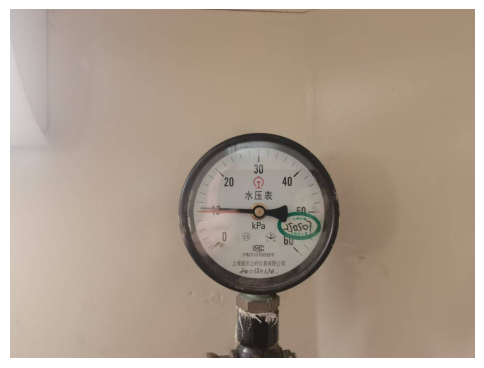

标注点检查 debug


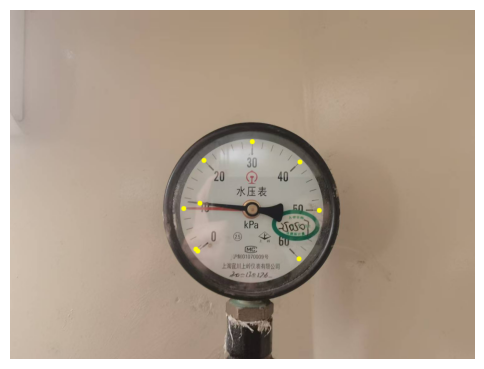

透视变化 debug


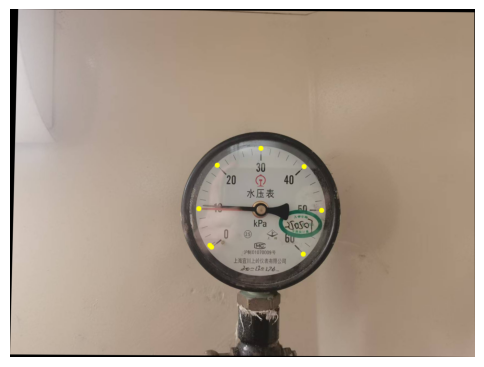

拟合圆检查 debug 


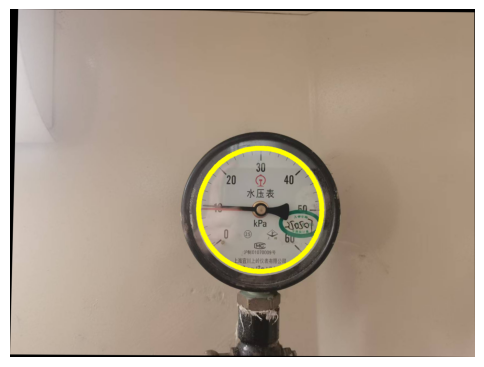

debug 扫描区域可视化


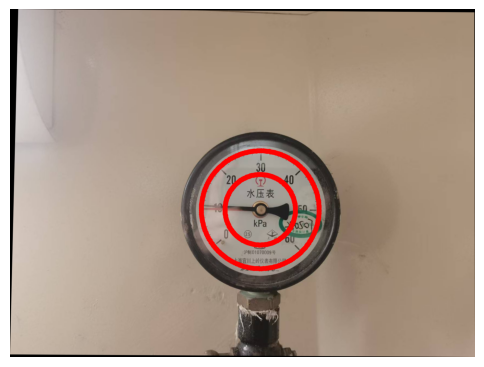

debug 切割表盘区域


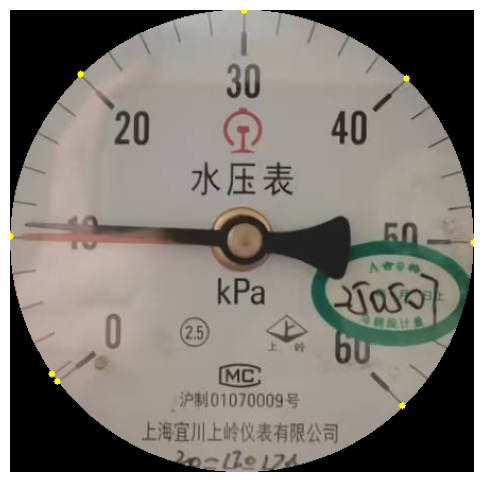

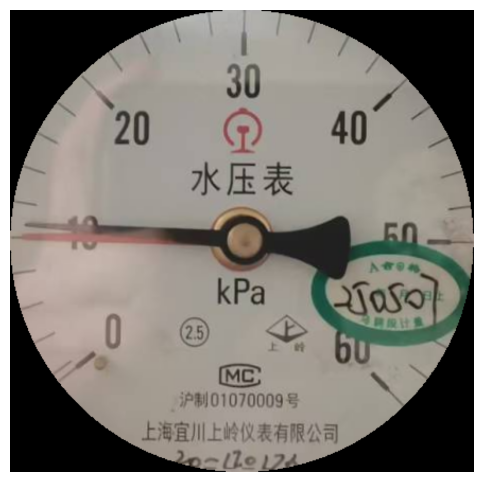

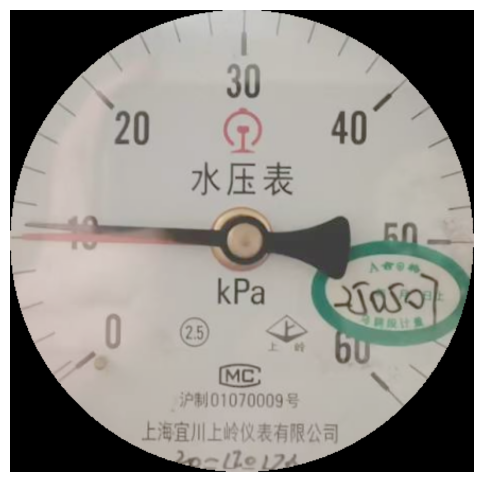

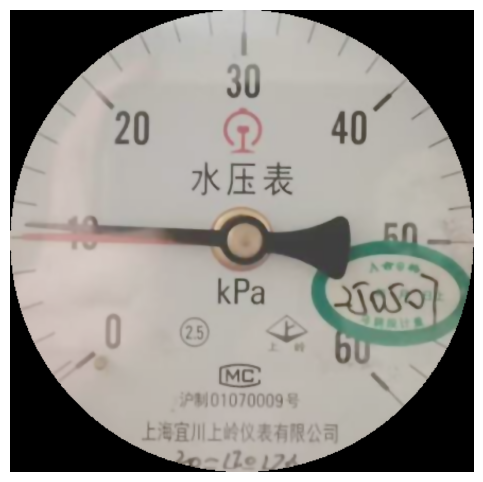

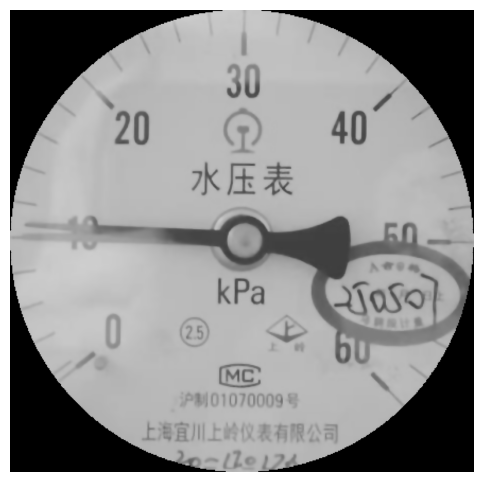

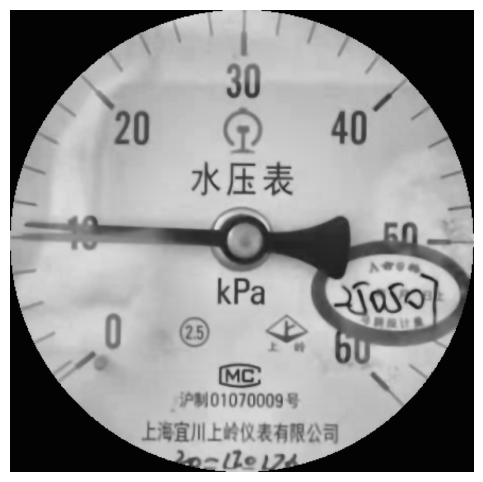

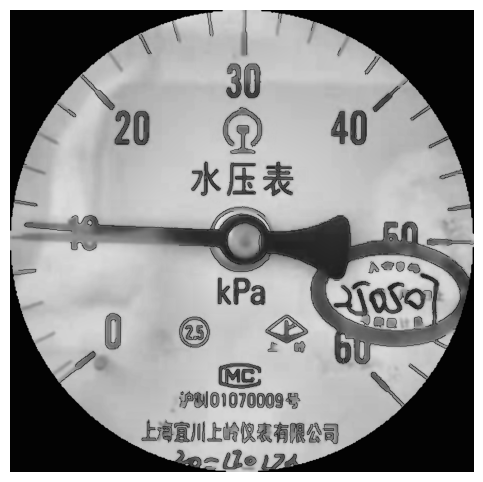

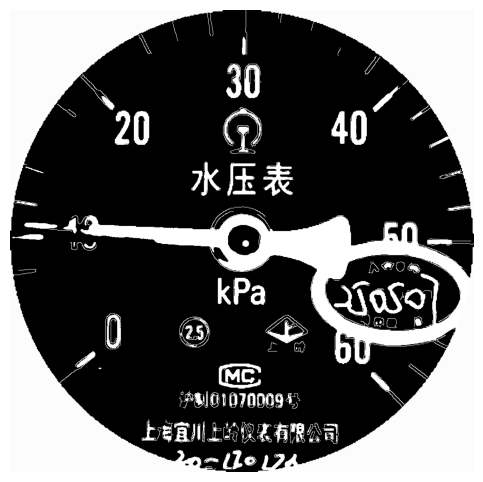

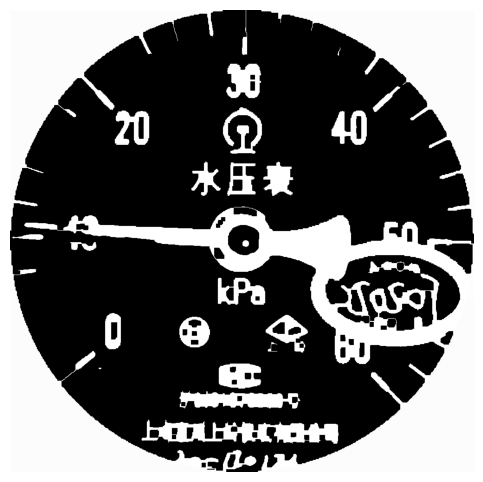

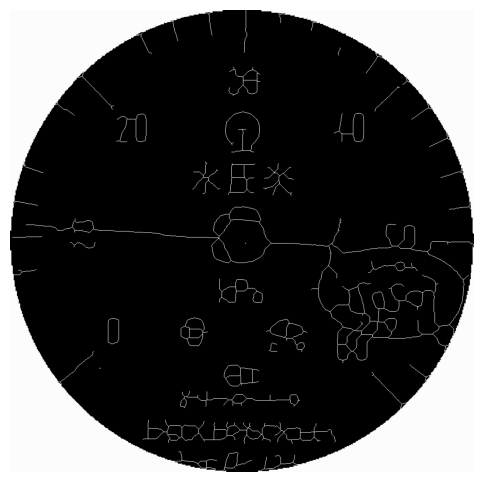

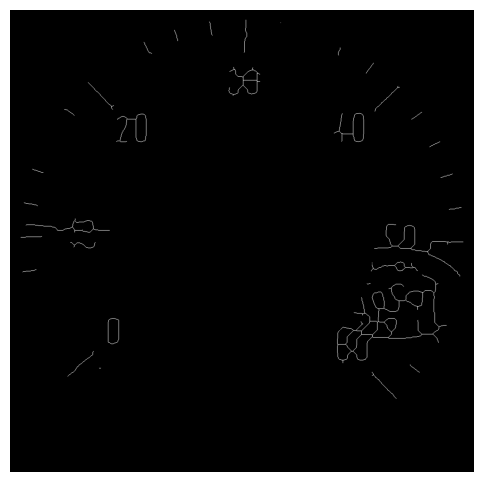

debug 切割表盘区域


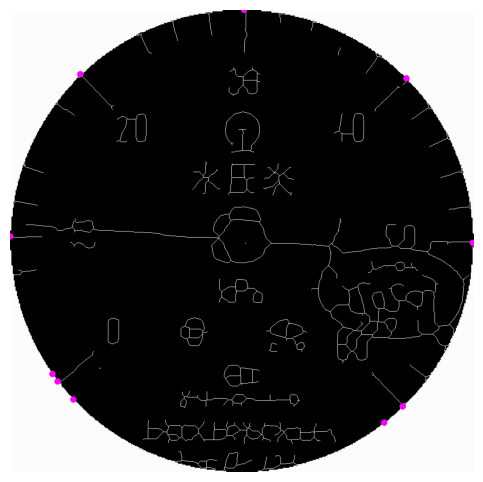

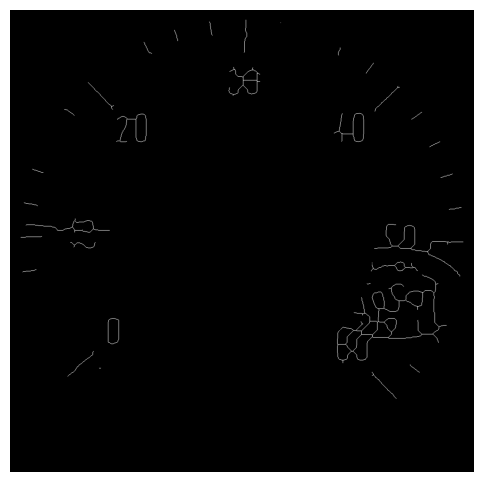

TypeError: 'NoneType' object is not iterable

In [17]:
test_path = 'source/1.1/img/tv20171227162937UVG250.jpg'
# test_path = 'source/1.2/img/tv20171227163039JZAH8I.jpg'
# test_path = 'source/1.3/img/1.jpg'
# test_path = 'source/1.4/img/Snipaste_2025-01-12_02-31-04.jpg'
# test_path = 'source/1.4/img/Snipaste_2025-01-12_02-30-47.jpg'
test_path = 'source/2.1/img/0644ad9906e898c7917d879715e7bc7.jpg'
# test_path = 'source/1.7/img/Snipaste_2025-01-13_18-07-07.jpg'

source_path = 'source/2.1/'
main(test_path, source_path, True)

In [19]:
# import os
#
# def get_files(directory):
#     # 遍历指定目录, 返回一个包含文件完整路径的列表 (不包括子目录)
#     files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
#     return files
#
# # 获取文件路径列表
# directory_path = os.path.join(source_path, 'img')  # 替换为你的目录路径
# file_list = get_files(directory_path)
#
# for file in file_list:
#     print(file)
#     main(file, source_path, False)
#     # img, maskCircle, maskRing = main(file, source_path, False)
#     # suffix = file.split('/')[-1]
#     # show_img(img)
#     # show_img(maskCircle)
#     # show_img(maskRing)
#
#     # save_cv_image_with_plt(img, os.path.join('output/img/', suffix))
#     # save_cv_image_with_plt(maskCircle, os.path.join('output/circle/', suffix))
#     # save_cv_image_with_plt(maskRing, os.path.join('output/ring/', suffix))
